In [5]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
#from time import time
#from tensorflow.python.keras.callbacks import TensorBoard 
#from keras.callbacks import TensorBoard

import tensorflow as tf

import cartpole_mod

# For model rendering
%matplotlib inline
import matplotlib.pyplot as plt
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from glob import glob
import os

In [6]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.train_info = []        # for Training accuracy & loss
        #self.log_dir = './logs/log_{}'.format(time())
        #self.tensorboard = TensorBoard(log_dir='./logs/test', update_freq=128)

    """Huber loss for Q Learning
    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate),
                      metrics=['accuracy'])
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        hist_batch = [] # for training accuracy & loss
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                # a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
                # target[0][action] = reward + self.gamma * t[np.argmax(a)]
            hist = self.model.fit(state, target, epochs=1, verbose=0)
            # hist has the length of batch size
            # Mean accuracy & loss should be calculated
            hist_batch.append([hist.history['acc'], hist.history['loss']])
        hist_batch = np.array(hist_batch)
        acc_loss = [np.mean(hist_batch[:,0]), np.mean(hist_batch[:,1])]
        self.train_info.append(acc_loss)    # Save the training acc & loss
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def get_history(self):       
        data = self.train_info
        self.train_info = []  # For new episode, it should be cleared
        return data

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Testing  /preurp/deep-q-learning/save/cartpole-dqn.h5
episode: 0/1, score: 74, e: 1.0



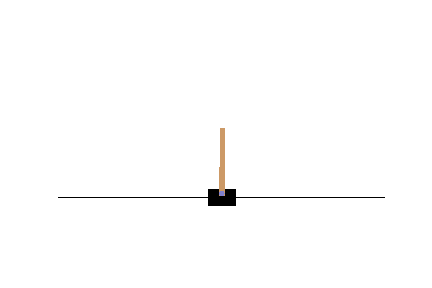
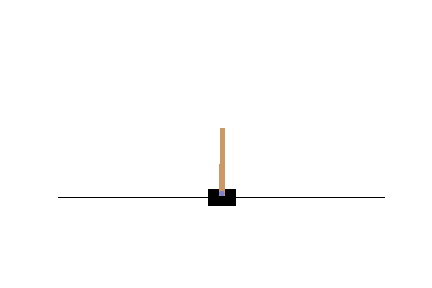
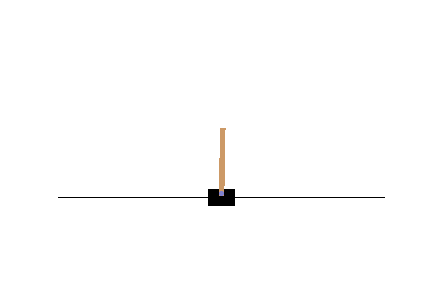
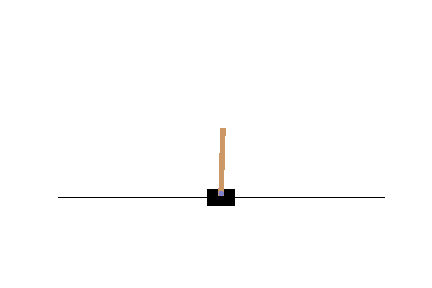
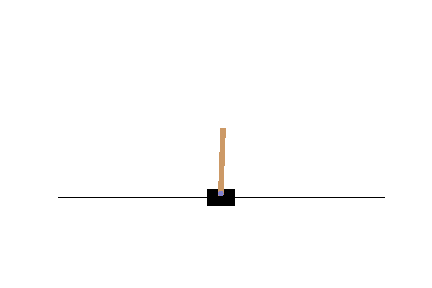
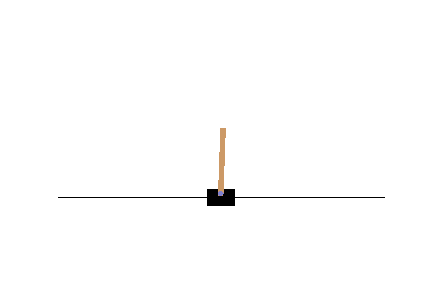
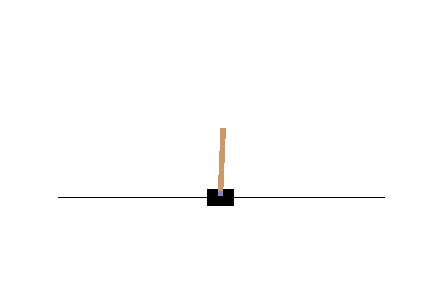
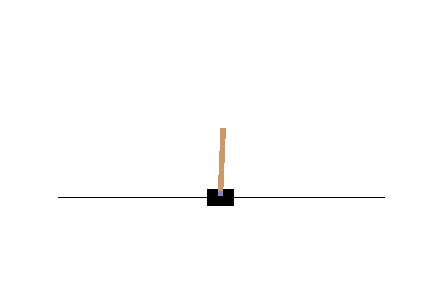
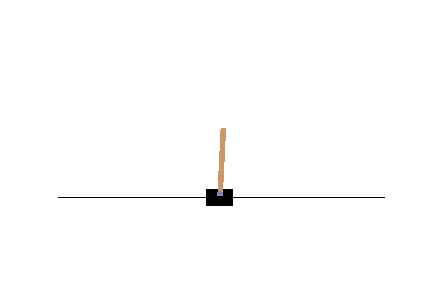
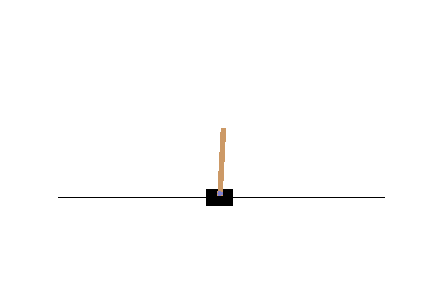
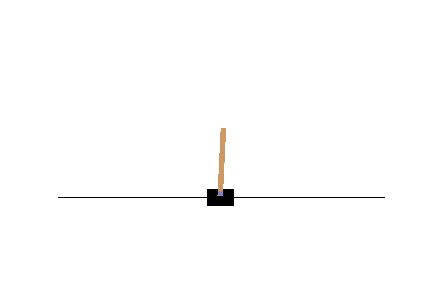
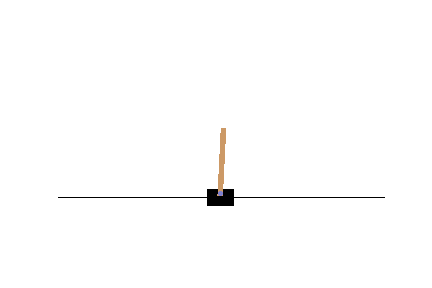
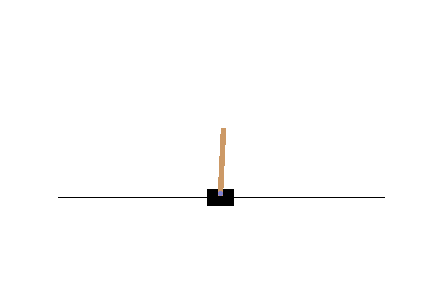
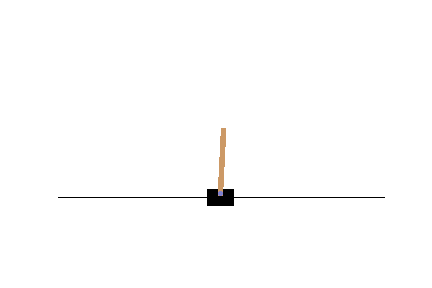
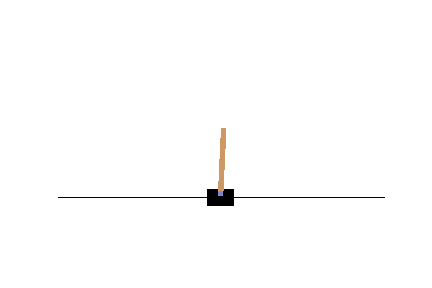
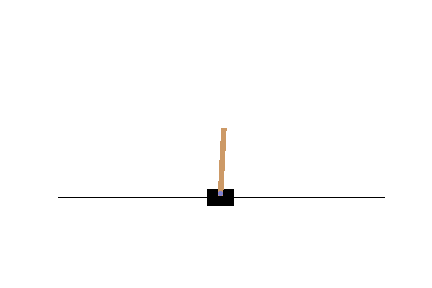
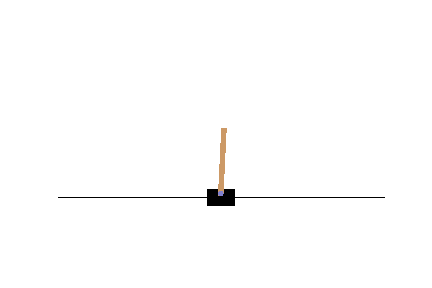
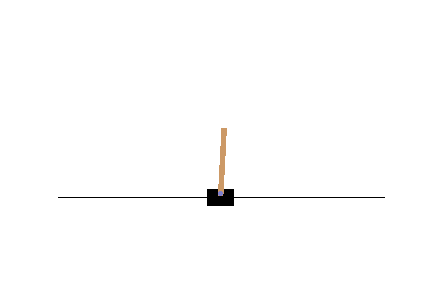
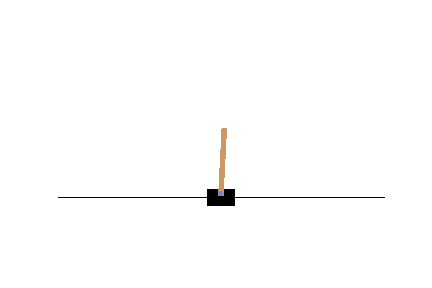
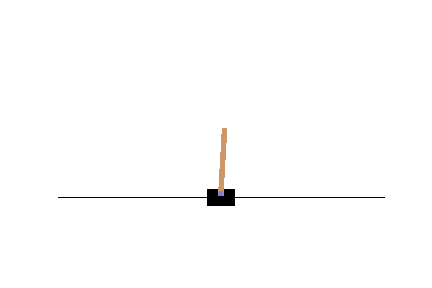
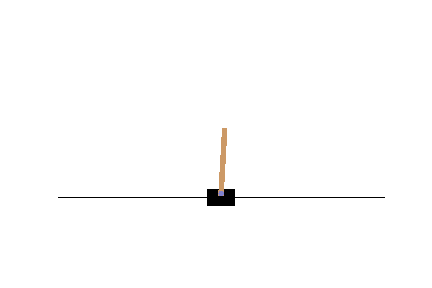
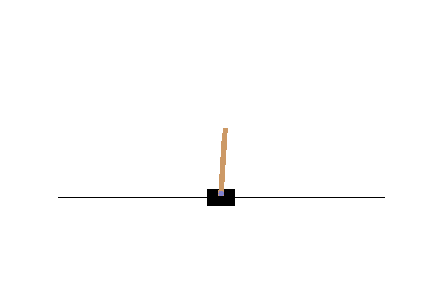
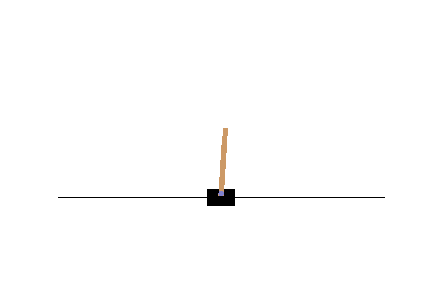
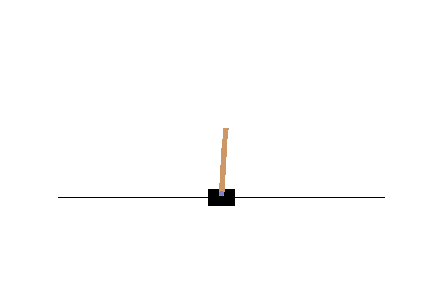
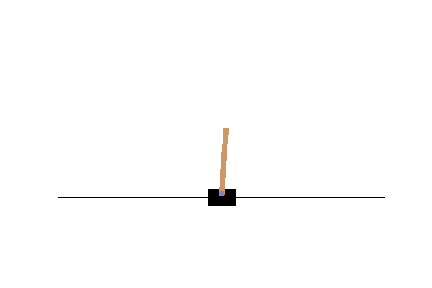
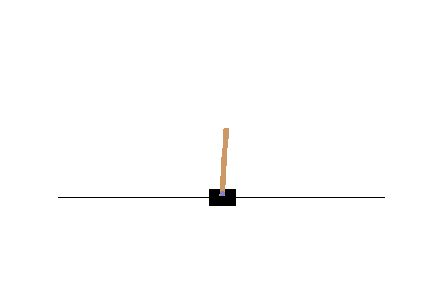
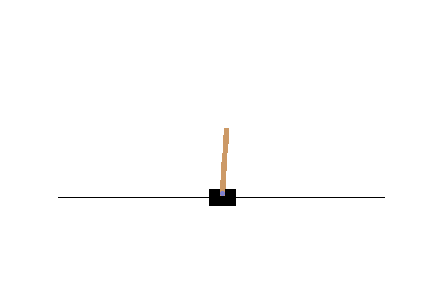
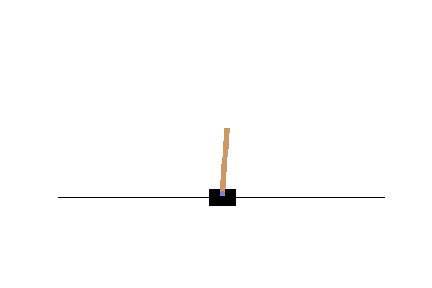
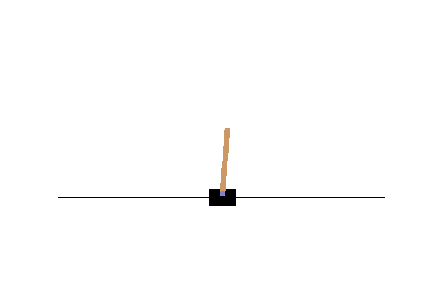
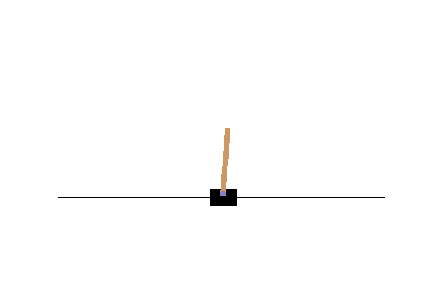
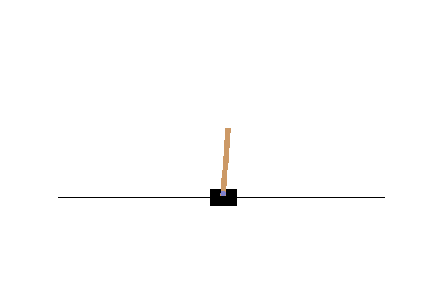
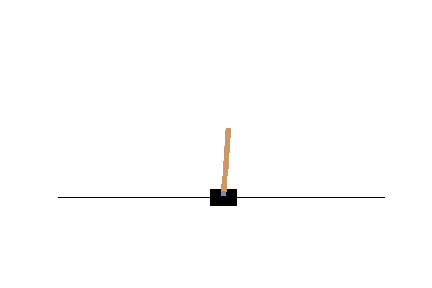
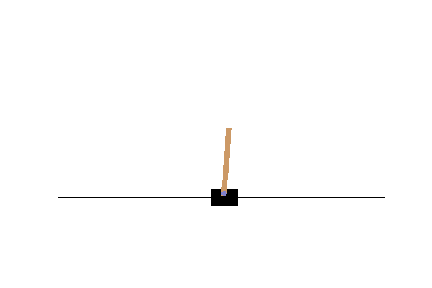
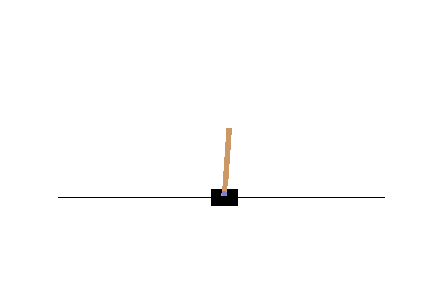
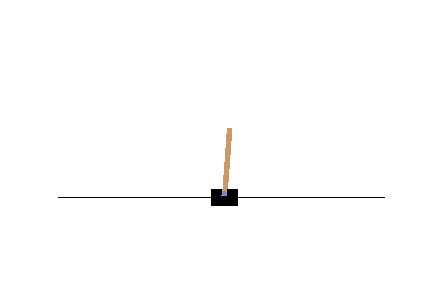
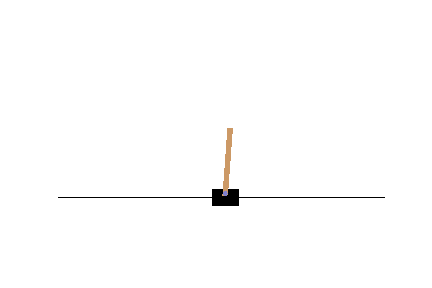
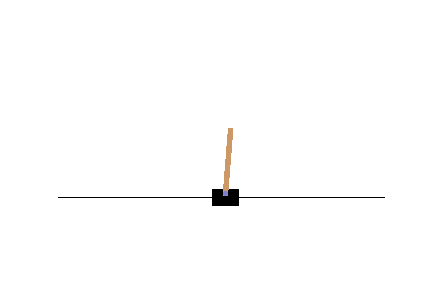
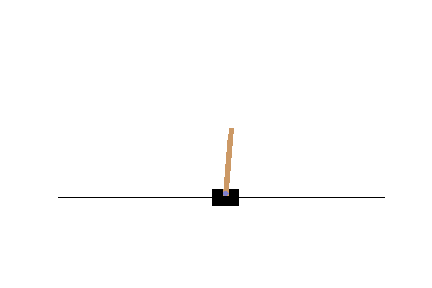
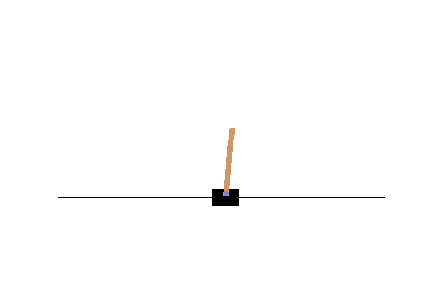
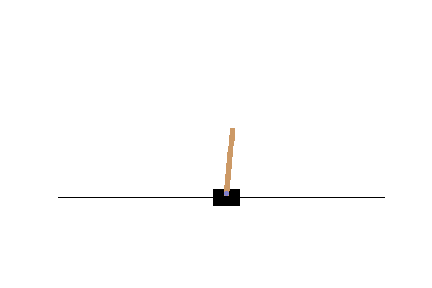
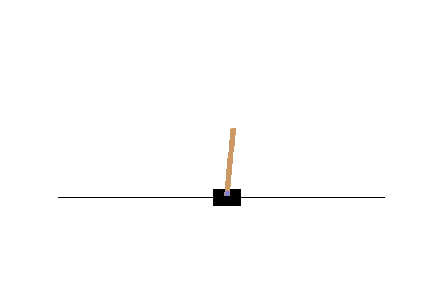
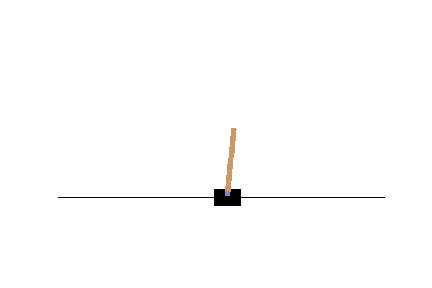
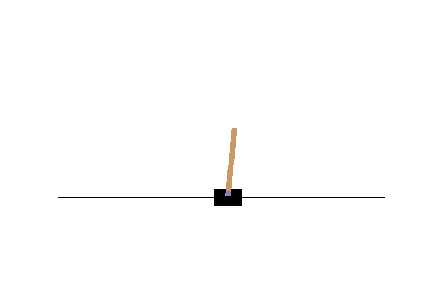
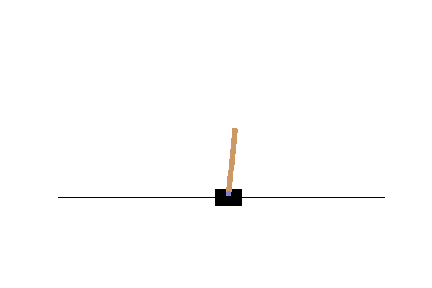
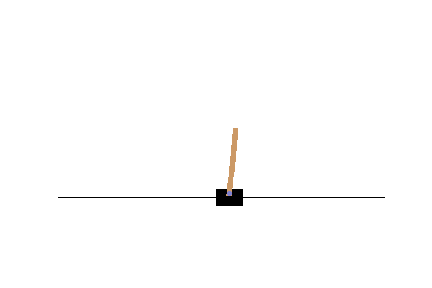
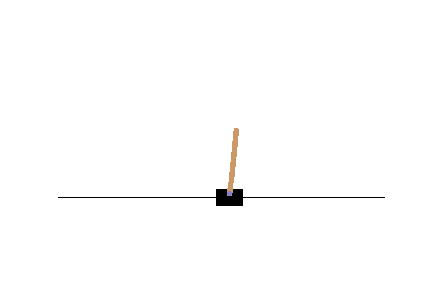
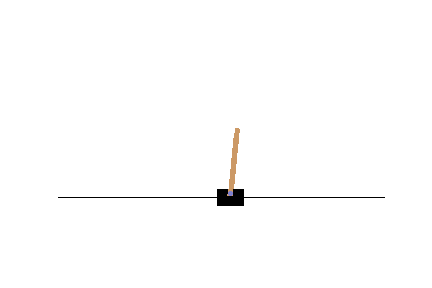
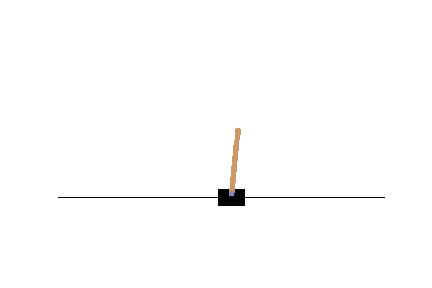
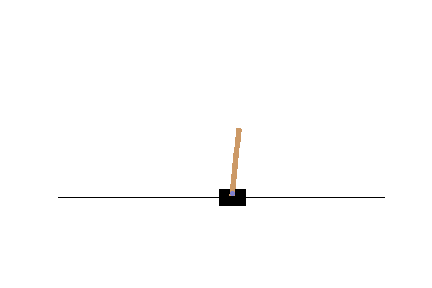
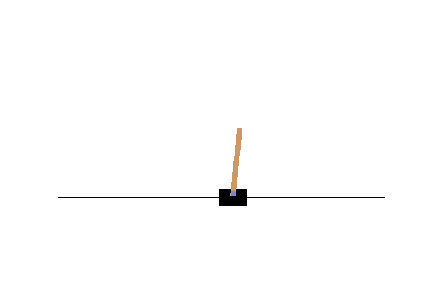
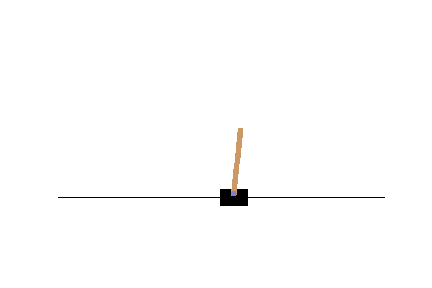
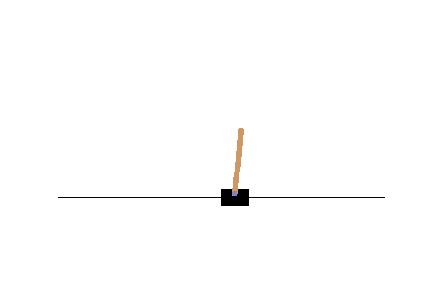
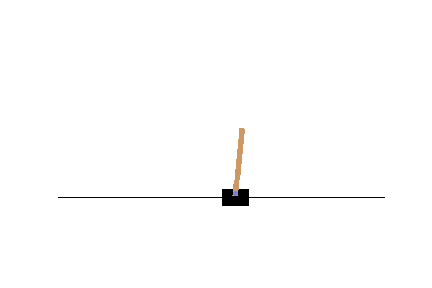
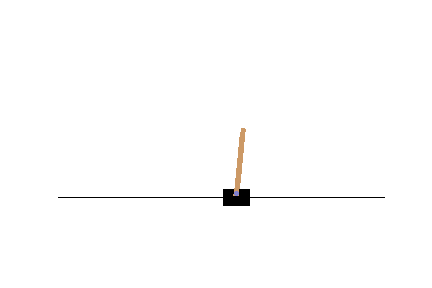
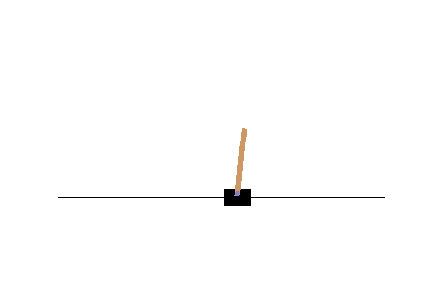
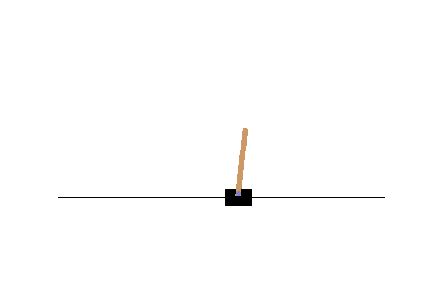
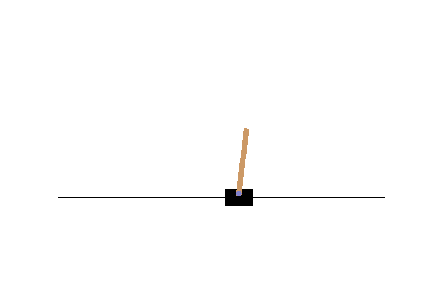
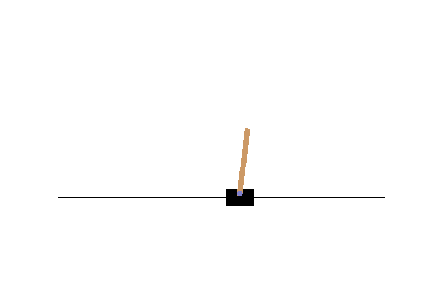
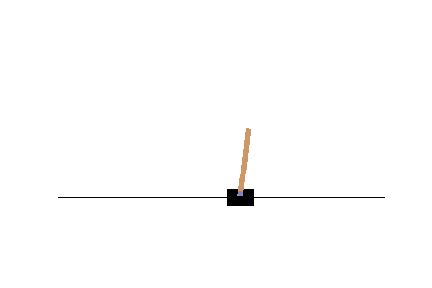
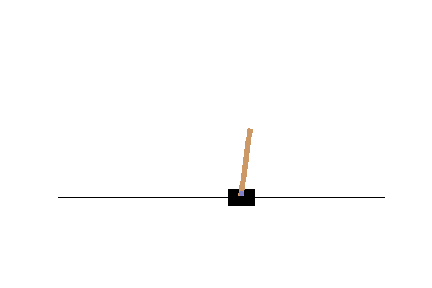
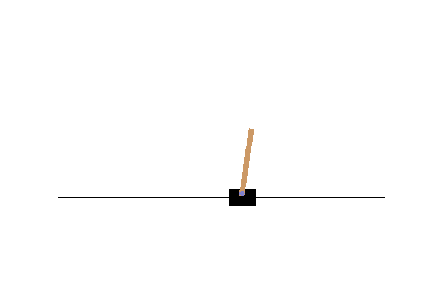
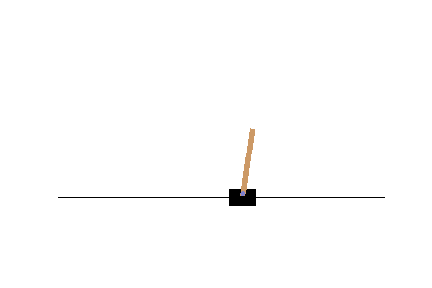
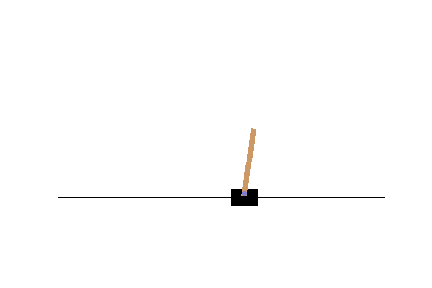
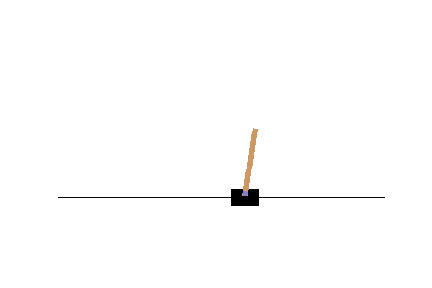
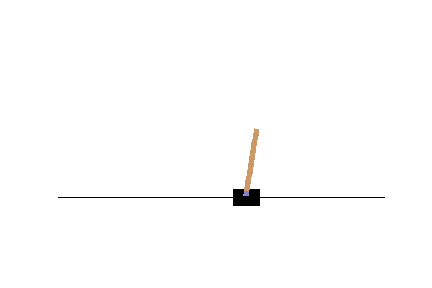
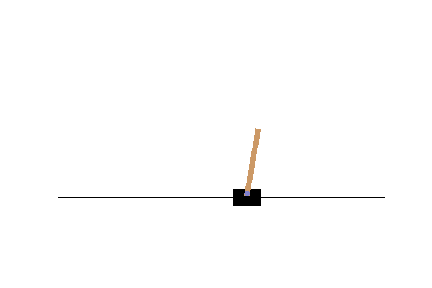
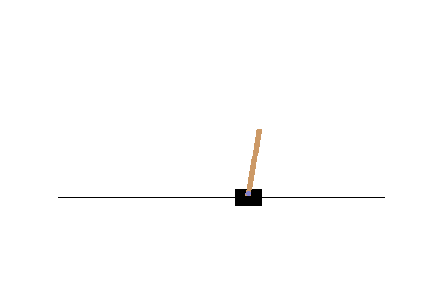
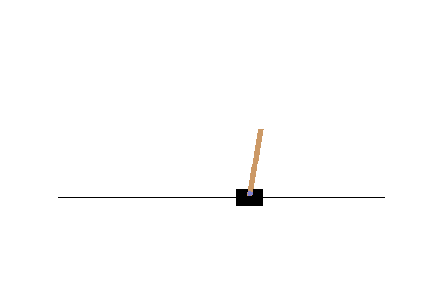
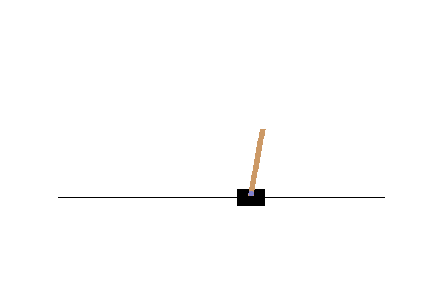
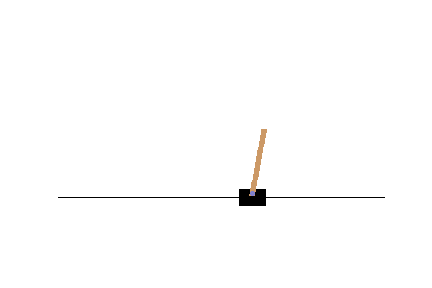
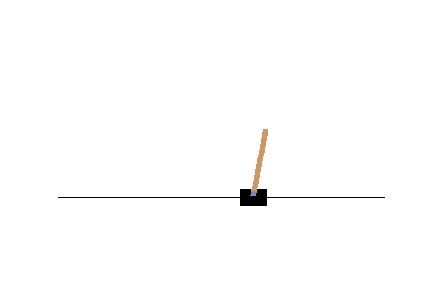
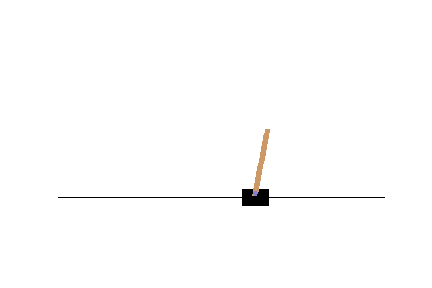
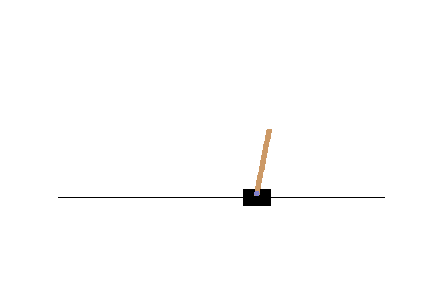
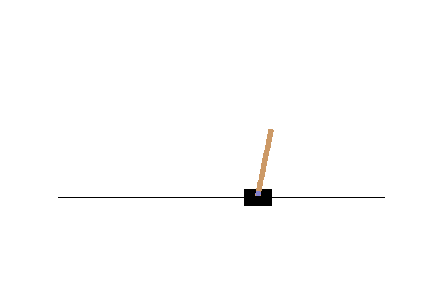
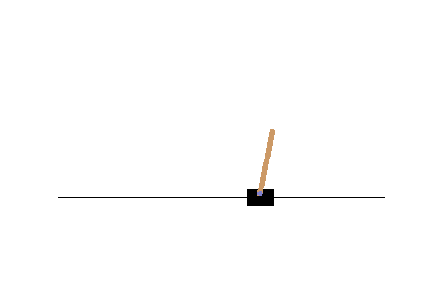

In [15]:
if __name__ == "__main__":
    
    model_folder = "/preurp/deep-q-learning/save/"
    model_list = [y for x in os.walk(model_folder) for y in glob(os.path.join(x[0], '*.h5'))]
    
    model_selection = 0
    model_path = model_list[model_selection]
    print("Testing ", model_path)
    EPISODES = 1
    
    config = tf.ConfigProto()
    config.gpu_options.visible_device_list = "0"
    config.gpu_options.per_process_gpu_memory_fraction = 0.2
    set_session(tf.Session(config=config))

    
    
    env = gym.make('CartPole-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    agent.load(model_path)
    done = False
    batch_size = 32
    
    history = {}
    history['score'] = []
    history['epsilon'] = []
    temp_score = 0
    temp_epsilon = 0
    
    # For rendering
    frames = []

    
    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            # env.render()
            frames.append(env.render(mode='rgb_array'))
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                temp_score = time
                temp_epsilon = agent.epsilon
                break
            
            if time == 499:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                temp_score = time
                temp_epsilon = agent.epsilon
                

        history[e] = agent.get_history()
        history['score'].append(temp_score)
        history['epsilon'].append(temp_epsilon)
        
    env.render()
    display_frames_as_gif(frames)
    